<a href="https://colab.research.google.com/github/jana-jovicic/Speech-to-Text/blob/master/speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jana-jovicic/Speech-to-Text.git

Cloning into 'Speech-to-Text'...
remote: Enumerating objects: 849, done.
remote: Counting objects: 100% (849/849), done.
remote: Compressing objects: 100% (847/847), done.
remote: Total 849 (delta 0), reused 843 (delta 0), pack-reused 0
Receiving objects: 100% (849/849), 17.73 MiB | 14.69 MiB/s, done.


In [13]:
!ls Speech-to-Text

dataset  README.md  speech_to_text.ipynb


In [0]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile 
import warnings
warnings.filterwarnings("ignore")

In [0]:
train_path = 'Speech-to-Text' + os.path.sep + 'dataset' + os.path.sep + 'train'
test_path = 'Speech-to-Text' + os.path.sep + 'dataset' + os.path.sep + 'test'

# Explore datatset

Plot amplitude over time of one audio recording:

[ 4.0688968e-04  3.1694559e-05 -4.5456085e-04 ...  5.9469097e-04
  8.1928732e-04  6.3908176e-04]
22050


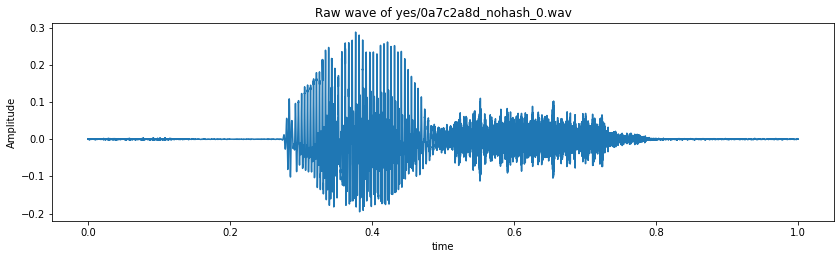

In [7]:
samples, sample_rate = librosa.load(train_path + os.path.sep + 'yes' + os.path.sep + '0a7c2a8d_nohash_0.wav')
print(samples)
print(sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [14]:
ipd.Audio(samples, rate=sample_rate)

Extract labels that represent voice comands:

In [17]:
labels = [d for d in os.listdir(train_path) if os.path.isdir(train_path + os.path.sep + d)]
print(labels)

['no', 'cat', 'dog', 'yes']


Get number of recordings for each voice command:

{'no': 154, 'cat': 160, 'dog': 150, 'yes': 157}


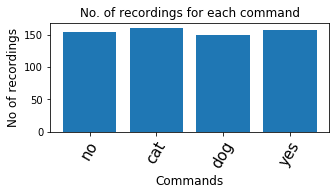

In [24]:
train_num_of_recordings_per_label = {}
for label in labels:
    train_num_of_recordings_per_label[label] = len([f for f in os.listdir(train_path + os.path.sep + label)])
print(train_num_of_recordings_per_label)

#plot
plt.figure(figsize=(5,2))
index = np.arange(len(labels))
plt.bar(index, train_num_of_recordings_per_label.values())
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

{'no': 53, 'cat': 50, 'dog': 50, 'yes': 58}


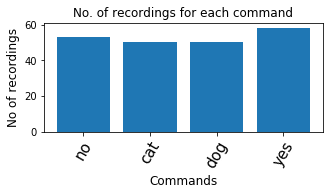

In [25]:
test_num_of_recordings_per_label = {}
for label in labels:
    test_num_of_recordings_per_label[label] = len([f for f in os.listdir(test_path + os.path.sep + label)])
print(test_num_of_recordings_per_label)

#plot
plt.figure(figsize=(5,2))
index = np.arange(len(labels))
plt.bar(index, test_num_of_recordings_per_label.values())
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

Get distribution of the duration of recordings:

(array([  1.,   1.,   4.,   2.,   8.,   4.,   7.,  16.,  12., 566.]),
 array([0.510875 , 0.5597875, 0.6087   , 0.6576125, 0.706525 , 0.7554375,
        0.80435  , 0.8532625, 0.902175 , 0.9510875, 1.       ]),
 <a list of 10 Patch objects>)

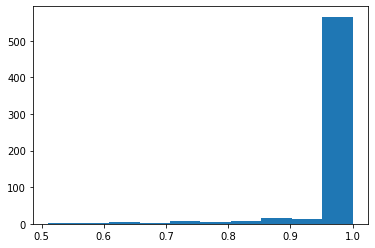

In [31]:
train_duration_of_recordings=[]
for label in labels:
  recordings = [f for f in os.listdir(train_path + os.path.sep + label) if f.endswith('.wav')]
  for record in recordings:
    sample_rate, samples = wavfile.read(train_path + os.path.sep + label + os.path.sep + record)
    # print(sample_rate)   # 16000
    train_duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(train_duration_of_recordings))

(array([  1.,   2.,   0.,   2.,   3.,   2.,   1.,   1.,   3., 196.]),
 array([0.64 , 0.676, 0.712, 0.748, 0.784, 0.82 , 0.856, 0.892, 0.928,
        0.964, 1.   ]),
 <a list of 10 Patch objects>)

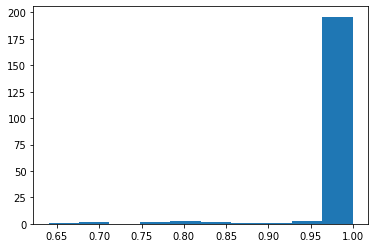

In [32]:
test_duration_of_recordings=[]
for label in labels:
  recordings = [f for f in os.listdir(test_path + os.path.sep + label) if f.endswith('.wav')]
  for record in recordings:
    sample_rate, samples = wavfile.read(test_path + os.path.sep + label + os.path.sep + record)
    # print(sample_rate)   # 16000
    test_duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(test_duration_of_recordings))